#AI-Assisted Detection of COVID-19 and Pneumonia in Chest X-Rays (CXRs)

### Loading the Data In

In [ ]:
#Import data
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
#To get this to work - create a shortcut of the APS360 Project folder and keep it in your main google drive
data_dir = "COVID-19_Radiography_Dataset"
!unzip 'gdrive/MyDrive/APS360 Project/COVID-19_Radiography_Dataset'


Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-2893.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-2894.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-2895.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-2896.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-2897.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-2898.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-2899.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-29.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-290.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-2900.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-2901.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-2902.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-2906.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-2907.png  
  inflating: C

In [ ]:
#Imports
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
import torchvision.models as models
import torchvision
from torchsummary import summary
import os
from PIL import Image
import cv2
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

%matplotlib inline


np.random.seed(36075)
torch.manual_seed(36075)

### EDA

Due to overwhelming class inbalance, random undersampling will be performed on the normal files.

In [ ]:
covid_files_before = os.listdir(data_dir+'/COVID')
normal_files_before = os.listdir(data_dir+'/Normal')
pneumonia_files_before = os.listdir(data_dir+'/Viral Pneumonia')

print('Number of COVID scans before undersampling:',len(covid_files_before))
print('Number of Normal scans before undersampling:',len(normal_files_before))
print('Number of Pneumonia scans before undersampling:',len(pneumonia_files_before))

Number of COVID scans before undersampling: 3616
Number of Normal scans before undersampling: 10192
Number of Pneumonia scans before undersampling: 1345


In [ ]:
np.random.seed(36075)

#Number of normal files to keep
normal_to_keep = np.random.randint(3000,5000)

new_normal_files = set(np.random.choice(os.listdir(data_dir+'/Normal'),size=normal_to_keep,replace=False))
for f in normal_files_before:
  if f not in new_normal_files:
    os.remove(data_dir+'/Normal/'+f)


In [ ]:
covid_files_after = os.listdir(data_dir+'/COVID')
normal_files_after = os.listdir(data_dir+'/Normal')
pneumonia_files_after = os.listdir(data_dir+'/Viral Pneumonia')

print('Number of COVID scans after undersampling:',len(covid_files_after))
print('Number of Normal scans after undersampling:',len(normal_files_after))
print('Number of Pneumonia scans after undersampling:',len(pneumonia_files_after))

Number of COVID scans after undersampling: 3616
Number of Normal scans after undersampling: 3732
Number of Pneumonia scans after undersampling: 1345


<Axes: xlabel='CXR Type', ylabel='Count'>

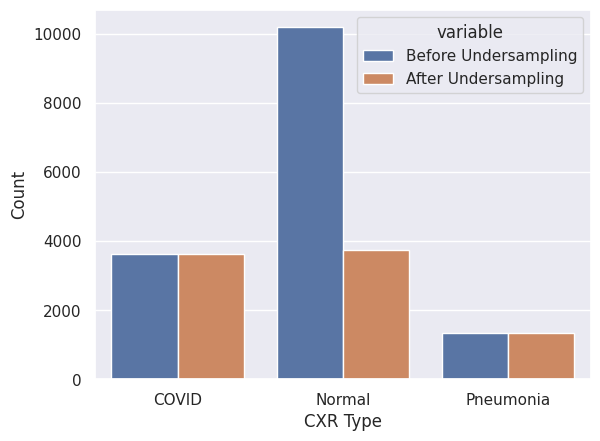

In [ ]:
sns.set_theme()
undersample_data = {'Before Undersampling':[len(covid_files_before),len(normal_files_before),len(pneumonia_files_before)],'After Undersampling':[len(covid_files_after),len(normal_files_after),len(pneumonia_files_after)]}

#sns.histplot(undersample_data)
plt.rcParams['figure.dpi'] = 100

temp = pd.melt(pd.DataFrame(undersample_data)).rename(columns={'value':'Count','type':'CXR Type'})
temp['CXR Type'] = ['COVID','Normal','Pneumonia','COVID','Normal','Pneumonia']
sns.barplot(data=temp,x='CXR Type',y='Count',hue='variable')

### Data Processing

To determine what type of normalization is to be applied: global histogram or CLAHE, histograms were plotted

Histograms need to be stretched so therefore use CLAHE

#### COVID

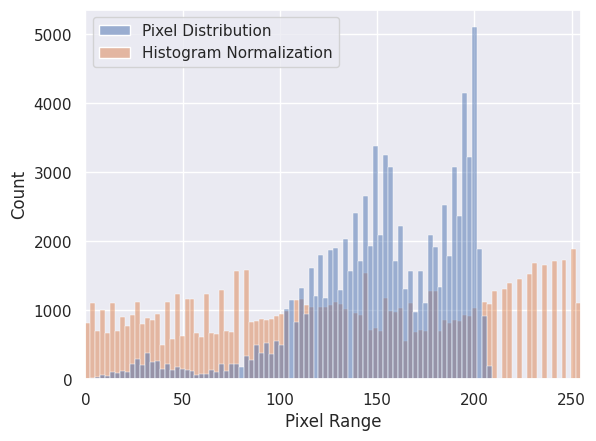

In [ ]:
#To first see whether CLAHE or global histogram should be applied
img = cv2.imread(data_dir+'/COVID/COVID-6.png')
grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
equ = cv2.equalizeHist(grayimg)
hist_data = {'Pixel Distribution':np.array(grayimg.flat),'Histogram Normalization':np.array(equ.flat)}
ax1 = sns.histplot(hist_data, bins=100)
plt.xlim(0,255)
plt.rcParams['figure.dpi'] = 100
ax1.set(xlabel='Pixel Range',ylabel='Count');


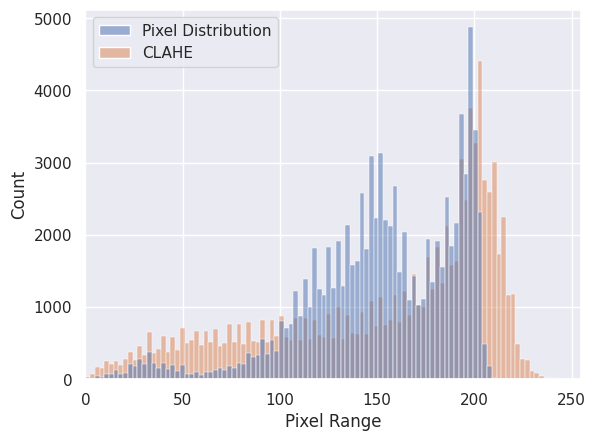

In [ ]:
img = cv2.imread(data_dir+'/COVID/COVID-6.png')
clahe = cv2.createCLAHE(clipLimit=3,tileGridSize=(4,4))
grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
clahe_img = clahe.apply(grayimg)
hist_data = {'Pixel Distribution':np.array(grayimg.flat),'CLAHE':np.array(clahe_img.flat)}
ax2 = sns.histplot(hist_data, bins=100)
plt.xlim(0,255)
plt.rcParams['figure.dpi'] = 100
ax2.set(xlabel='Pixel Range',ylabel='Count');



(-0.5, 298.5, 298.5, -0.5)

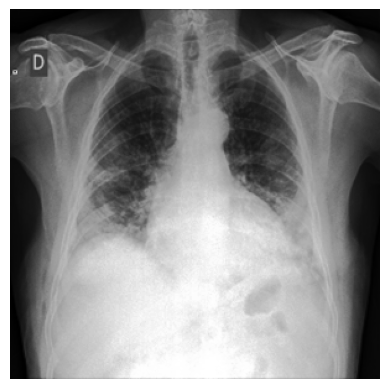

In [ ]:
plt.imshow(equ,cmap='gray')
plt.axis('off')

(-0.5, 298.5, 298.5, -0.5)

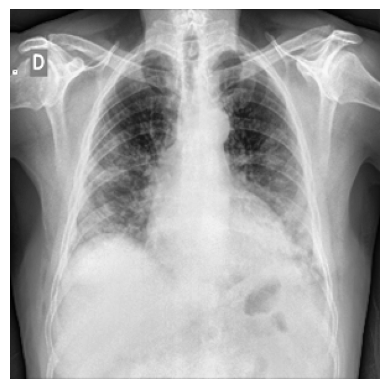

In [ ]:
plt.imshow(clahe_img,cmap='gray')
plt.axis('off')

#### Viral Pneumonia

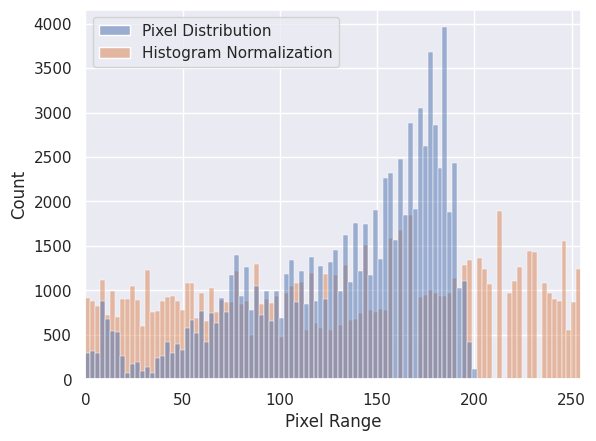

In [ ]:
sns.set_theme()
img = cv2.imread(data_dir+'/Viral Pneumonia/Viral Pneumonia-10.png')
grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
equ = cv2.equalizeHist(grayimg)
hist_data = {'Pixel Distribution':np.array(grayimg.flat),'Histogram Normalization':np.array(equ.flat)}
ax1 = sns.histplot(hist_data, bins=100)
plt.xlim(0,255)
plt.rcParams['figure.dpi'] = 100
ax1.set(xlabel='Pixel Range',ylabel='Count');


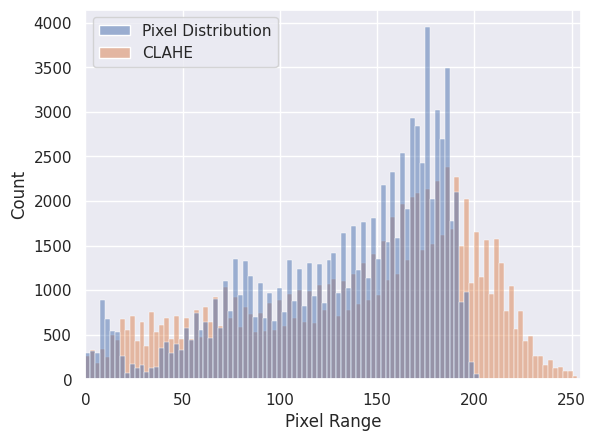

In [ ]:
img = cv2.imread(data_dir+'/Viral Pneumonia/Viral Pneumonia-10.png')
clahe = cv2.createCLAHE(clipLimit=3,tileGridSize=(4,4))
grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
clahe_img = clahe.apply(grayimg)
hist_data = {'Pixel Distribution':np.array(grayimg.flat),'CLAHE':np.array(clahe_img.flat)}
ax2 = sns.histplot(hist_data, bins=100)
plt.xlim(0,255)
plt.rcParams['figure.dpi'] = 100
ax2.set(xlabel='Pixel Range',ylabel='Count');



(-0.5, 298.5, 298.5, -0.5)

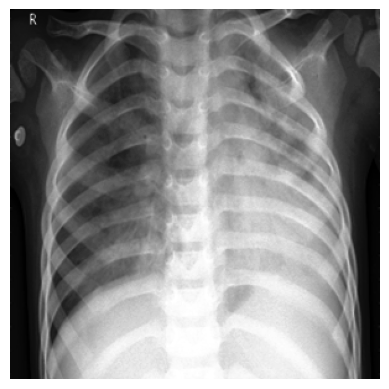

In [ ]:
plt.imshow(equ,cmap='gray')
plt.axis('off')

(-0.5, 298.5, 298.5, -0.5)

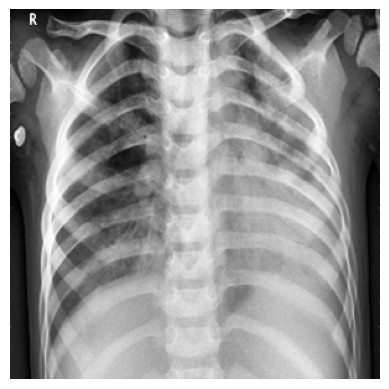

In [ ]:
plt.imshow(clahe_img,cmap='gray')
plt.axis('off')

#### Normal

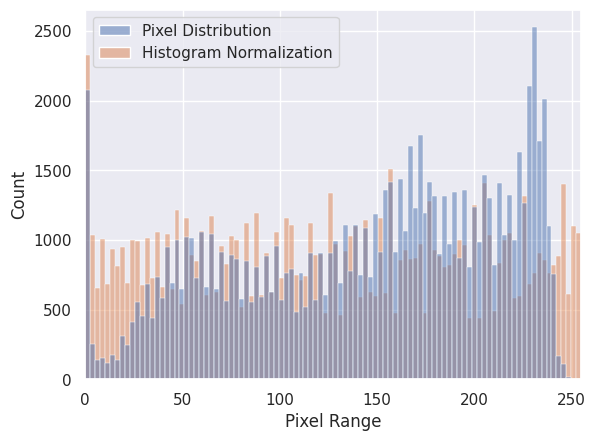

In [ ]:
#To first see whether CLAHE or global histogram should be applied
sns.set_theme()
img = cv2.imread(data_dir+'/Normal/Normal-16.png')
grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
equ = cv2.equalizeHist(grayimg)
hist_data = {'Pixel Distribution':np.array(grayimg.flat),'Histogram Normalization':np.array(equ.flat)}
ax1 = sns.histplot(hist_data, bins=100)
plt.xlim(0,255)
plt.rcParams['figure.dpi'] = 100
ax1.set(xlabel='Pixel Range',ylabel='Count');


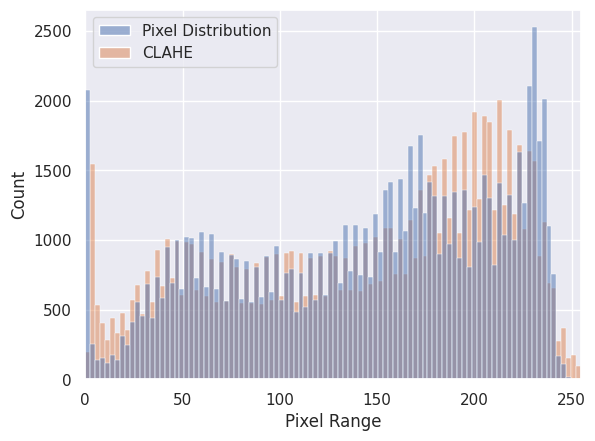

In [ ]:
img = cv2.imread(data_dir+'/Normal/Normal-16.png')
clahe = cv2.createCLAHE(clipLimit=3,tileGridSize=(4,4))
grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
clahe_img = clahe.apply(grayimg)
hist_data = {'Pixel Distribution':np.array(grayimg.flat),'CLAHE':np.array(clahe_img.flat)}
ax2 = sns.histplot(hist_data, bins=100)
plt.xlim(0,255)
plt.rcParams['figure.dpi'] = 100
ax2.set(xlabel='Pixel Range',ylabel='Count');



(-0.5, 298.5, 298.5, -0.5)

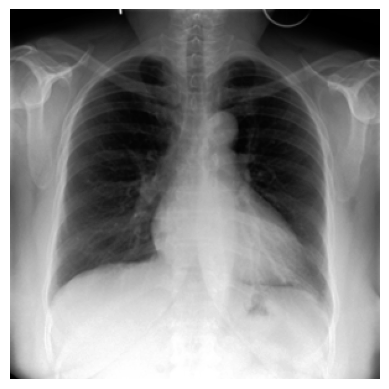

In [ ]:
plt.imshow(equ,cmap='gray')
plt.axis('off')

(-0.5, 298.5, 298.5, -0.5)

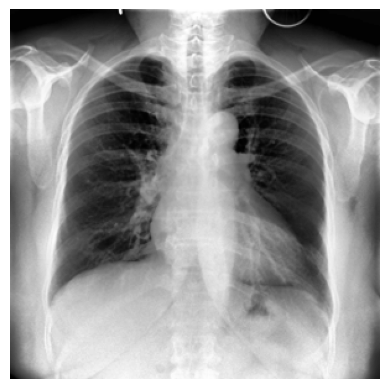

In [ ]:
plt.imshow(clahe_img,cmap='gray')
plt.axis('off')

In [ ]:
#From https://medium.com/analytics-vidhya/creating-a-custom-dataset-and-dataloader-in-pytorch-76f210a1df5d
class CustomDataset():
    def __init__(self,data_dir):
        file_list = glob.glob(data_dir + "/*")
        self.data = []
        for class_path in file_list:
            if class_path != data_dir+'/Lung_Opacity':
              class_name = class_path.split("/")[-1]
              for img_path in glob.glob(class_path + "/*.png"):
                  self.data.append([img_path, class_name])
        self.class_map = {"Normal" : 0, "Viral Pneumonia": 1, "COVID":2}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = clahe.apply(grayimg)
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img)
        #Channel first format
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

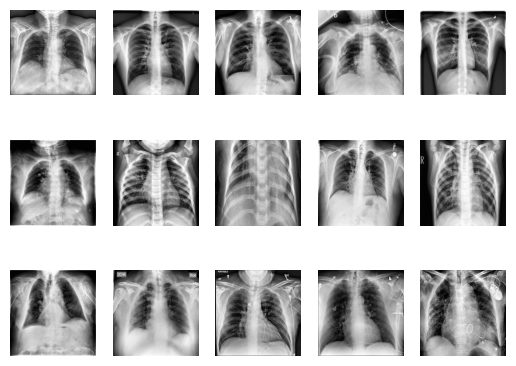

In [ ]:
#MODIFIED FROM LAB 2
def get_data_loaders(batch_size):


  #HISTOGRAM EQUILIZATION
  transform = transforms.Compose(
        [transforms.ToTensor()])

  data = torch.utils.data.DataLoader(CustomDataset(data_dir), batch_size=batch_size, shuffle=True)
  #Split the data based on 80-20-20
  total_data = len(data)
  num_train = int(0.8*total_data)
  num_test = total_data-num_train
  num_val = int(0.2*num_train)
  num_train -= num_val

  train, val, test = torch.utils.data.random_split(data.dataset, (num_train,num_val,num_test))
  train_loader = torch.utils.data.DataLoader(train,batch_size,num_workers=1)
  val_loader = torch.utils.data.DataLoader(val,batch_size,num_workers=1)
  test_loader = torch.utils.data.DataLoader(test,batch_size,num_workers=1)

  return train_loader,val_loader,test_loader

train_loader,val_loader,test_loader = get_data_loaders(1)

#FROM LAB 2
#Show some sample images from train loader (demonstrates that the data was shuffeld)
k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    # normalize pixel intensity values to [0, 1]
    #img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(image,cmap='gray')

    k += 1
    if k > 14:
        break

Number of images in training:	5564
Number of images in validation:	1390
Number of images in testing:	1739


[Text(0, 0.5, 'Count')]

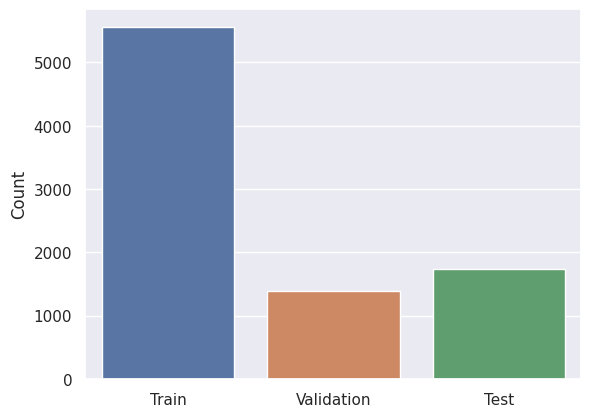

In [ ]:
no_train = 0
no_val = 0
no_test = 0



for images, labels in train_loader:
  no_train += 1

for images, labels in val_loader:
  no_val += 1

for images, labels in test_loader:
  no_test += 1


print('Number of images in training:\t'+str(no_train))
print('Number of images in validation:\t'+str(no_val))
print('Number of images in testing:\t'+str(no_test))

ax3 = sns.barplot(x=['Train','Validation','Test'],y=[no_train,no_val,no_test])
ax3.set(ylabel='Count')

### Baseline Model

In [ ]:
def create_train_test(data_loader):
  X,y = [],[]

  for img,label in data_loader:
    X.append(img.squeeze(0).numpy().flatten()) #make data 1 dimension 299x299 features
    y.append(label.numpy()[0][0])



  return X,y

In [ ]:
X_train, y_train = create_train_test(train_loader)
X_val, y_val = create_train_test(val_loader)
X_test, y_test = create_train_test(test_loader)


In [ ]:
X_train = np.vstack(X_train)
X_val = np.vstack(X_val)
X_test = np.vstack(X_test)

X_train.shape

(5564, 89401)

In [ ]:
#Adapted from https://www.codementor.io/@agarrahul01/multiclass-classification-using-random-forest-on-scikit-learn-library-hkk4lwawu

classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42)

In [ ]:
factor = pd.factorize(["Normal", "Viral Pneumonia", "COVID"])
definitions = factor[1]

# Predicting the Test set results
y_pred = classifier.predict(X_val)
#Reverse factorize (converting y_pred from 0s,1s and 2s)
reversefactor = dict(zip(range(3),definitions))
y_test = np.vectorize(reversefactor.get)(y_val)
y_pred = np.vectorize(reversefactor.get)(y_pred)
# Making the Confusion Matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))

Predicted        COVID  Normal  Viral Pneumonia
Actual                                         
COVID              463      85               10
Normal              71     523               22
Viral Pneumonia     15      19              182


In [ ]:
train_score = classifier.score(X_train, y_train)

val_score = classifier.score(X_val, y_val)

print( "training score is : " , train_score)
print( "val score is : " , val_score)

training score is :  0.9947879223580158
val score is :  0.8402877697841726


#### Grid Search

In [ ]:
N_estimators =  [ 10,  40,  100]
Criterions = ['gini', 'entropy', 'log_loss']
Max_features = ['sqrt', 'log2']
Max_depth = [None,12,50]

for n in N_estimators:
  for c in Criterions:
    for m in Max_features:
      for d in Max_depth:
        mdl = RandomForestClassifier(n_estimators = n, criterion = c, max_features = m, max_depth=d, random_state = 42)
        mdl.fit(X_train, y_train)
        train_score = mdl.score(X_train, y_train)
        val_score = mdl.score(X_val, y_val)
        print("for params", n,c,m,d)
        print( "training score is : " , train_score)
        print( "val score is : " , val_score)
        print('\n')



for params 10 gini sqrt None
training score is :  0.9951473759884975
val score is :  0.823021582733813


for params 10 gini sqrt 12
training score is :  0.9872393961179008
val score is :  0.8402877697841726


for params 10 gini sqrt 50
training score is :  0.9951473759884975
val score is :  0.823021582733813


for params 10 gini log2 None
training score is :  0.9953271028037384
val score is :  0.8122302158273381


for params 10 gini log2 12
training score is :  0.9800503235082675
val score is :  0.7856115107913669


for params 10 gini log2 50
training score is :  0.9953271028037384
val score is :  0.8122302158273381


for params 10 entropy sqrt None
training score is :  0.9947879223580158
val score is :  0.8402877697841726


for params 10 entropy sqrt 12
training score is :  0.9955068296189792
val score is :  0.8294964028776979


for params 10 entropy sqrt 50
training score is :  0.9947879223580158
val score is :  0.8402877697841726


for params 10 entropy log2 None
training score is :

Best params (of highest val score): 100 log_loss sqrt None

Val score of 0.8827338129496403


In [ ]:
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'log_loss', max_features = 'sqrt', max_depth=None, random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='log_loss', random_state=42)

In [ ]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
#Reverse factorize (converting y_pred from 0s,1s and 2s)
reversefactor = dict(zip(range(3),definitions))
y_test2 = np.vectorize(reversefactor.get)(y_test)
y_pred = np.vectorize(reversefactor.get)(y_pred)
# Making the Confusion Matrix
print(pd.crosstab(y_test2, y_pred, rownames=['Actual'], colnames=['Predicted']))

Predicted        COVID  Normal  Viral Pneumonia
Actual                                         
COVID              613      73                9
Normal              96     653               11
Viral Pneumonia     23       5              256


In [ ]:
train_score = classifier.score(X_train, y_train)

val_score = classifier.score(X_val, y_val) #scoreing on X_test anf y -test gives bugs

test_score = classifier.score(X_test, y_test)


print( "training score is : " , train_score)
print( "val score is : " , val_score)
print( "test score is : " , test_score)

training score is :  1.0
val score is :  0.8827338129496403
test score is :  0.875215641173088


#### Model Evaluation

Normal:
	precision: 0.859
	recall: 0.893
Viral Pneumonia:
	precision: 0.882
	recall: 0.837
COVID:
	precision: 0.901
	recall: 0.928


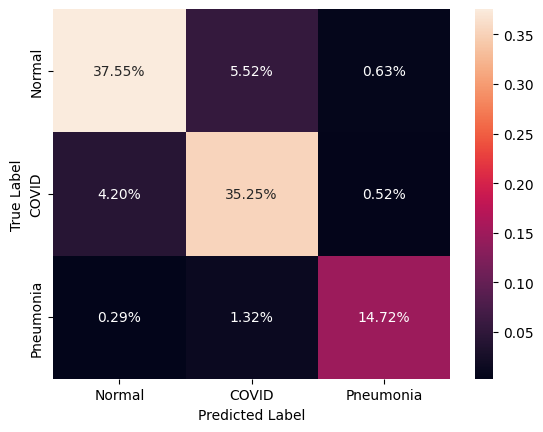

In [ ]:
#Basline model confusion matrix


#Baseline model results
cf_matrix = np.array([[653, 96, 11],[73, 613, 9], [5, 23, 256]])

classes = {"Normal" : 0, "Viral Pneumonia": 1, "COVID":2}

for i  in classes:
  print(i+":")
  precision = cf_matrix[classes[i]][classes[i]]/sum(cf_matrix[classes[i],:])
  recall = cf_matrix[classes[i]][classes[i]]/sum(cf_matrix[:,classes[i]])
  print('\tprecision: {}'.format(round(precision,3)))
  print('\trecall: {}'.format(round(recall,3)))

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix),annot=True,fmt='.2%',xticklabels=['Normal','COVID','Pneumonia'],yticklabels=['Normal','COVID','Pneumonia'])
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label');

### ResNet

In [ ]:
#To get Colab GPU usage (adapted from https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available)
def printm():
 import GPUtil as GPU
 GPUs = GPU.getGPUs()
 # XXX: only one GPU on Colab and isn’t guaranteed
 gpu = GPUs[0]
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

def train(model, model_name, train_val_loaders, use_cuda, num_epochs=5, learning_rate=1e-4, batch_size = 64, no_layers = 1, optimizer_name="adam"):
    """ Training loop. You should update this."""
    torch.manual_seed(36075)

    ### TODO: Test around (for optimizer: SGD?)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    ###

    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    start_time = time.time()

    model_folder = "model_{0}_lr{1}_bs{2}_layers{3}_optim{4}_epoch{5}".format(model_name,learning_rate,batch_size,no_layers,optimizer_name,num_epochs-1)
    !mkdir $model_folder

    for epoch in range(num_epochs):
      running_train_loss = 0.0
      running_train_acc = 0.0
      running_val_loss = 0.0
      running_val_acc = 0.0
      for phase in ['train','validation']:
        if phase == 'train':
          model = model.train()
        else:
          model = model.eval()

        for img,label in train_val_loaders[phase]:


            #Overlay 3 greyscale images to mimic RGB chanels
            rgb_batch = np.transpose(np.repeat(img[..., np.newaxis], 3, -1).squeeze(1),(0,3,1,2))
            if use_cuda and torch.cuda.is_available():
              rgb_batch = rgb_batch.cuda()
              label = torch.flatten(label.cuda())
            elif not use_cuda:
              label = torch.flatten(label.type(torch.LongTensor))
            outputs = model(rgb_batch)

            #Specific dtypes required for CELoss
            #label = torch.flatten(label.type(torch.LongTensor))
            #print(outputs)
            #outputs = torch.tensor(torch.argmax(outputs,dim=1,keepdim=True),dtype=float)
            #print(outputs,label)
            loss = criterion(outputs, label)
            if phase=='train':
              loss.backward()
              optimizer.step()
              optimizer.zero_grad()


            #train_acc[epoch],train_loss[epoch] = evaluate(model, train_loader, criterion)
            #val_acc[epoch],val_loss[epoch] = evaluate(model, valid_loader, criterion)
            pred = outputs.max(1, keepdim=True)[1]
            if phase == 'train':
              running_train_loss += loss.item()

              running_train_acc += pred.eq(label.view_as(pred)).sum().item()
            else:
              running_val_loss += loss.item()
              running_val_acc += pred.eq(label.view_as(pred)).sum().item()


        train_acc[epoch] = running_train_acc/no_train
        train_loss[epoch] = running_train_loss/no_train
        val_acc[epoch] = running_val_acc/no_val
        val_loss[epoch] = running_val_loss/no_val

      print(("Epoch {}: Train acc: {}, Train loss: {} |"+
            "Validation acc: {}, Validation loss: {}").format(
                epoch + 1,
                train_acc[epoch],
                train_loss[epoch],
                val_acc[epoch],
                val_loss[epoch]))

      printm()

      #Checkpoint
      model_path = model_folder+"/"+"model_{0}_lr{1}_bs{2}_layers{3}_optim{4}_epoch{5}".format(model_name,learning_rate,batch_size,no_layers,optimizer_name,epoch)
      torch.save(model.state_dict(), model_path)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    return train_acc, train_loss, val_acc, val_loss

def plot_training_curve(train_acc, train_loss, val_acc, val_loss):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    plt.title("Train vs Validation Accuracy")
    n = len(train_acc) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()


#FROM TUTORIAL 2
def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """

    correct = 0
    total = 0
    total_loss = 0.0
    total_epoch = 0
    for imgs, labels in loader:

        rgb_batch = np.transpose(np.repeat(imgs[..., np.newaxis], 3, -1).squeeze(1),(0,3,1,2))
        if use_cuda and torch.cuda.is_available():
          rgb_batch = rgb_batch.cuda()
          labels = torch.flatten(labels.cuda())
        elif not use_cuda:
          labels = torch.flatten(labels.type(torch.LongTensor))
        output = net(rgb_batch)
        loss = criterion(output, labels)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total_loss += loss.item()
        total_epoch += len(labels)
        total += imgs.shape[0]
    loss = float(total_loss) / total
    accuracy = correct/total
    return accuracy, loss

In [ ]:
class Flatten(torch.nn.Module):
    """
    Custom flatten module like what is available in PyTorch.
    """

    def forward(self, input):
        return input.view(input.size(0), -1)




In [ ]:
!nvidia-smi

#To reset GPU - runtime must be restarted afterwards

# !pip install numba
# from numba import cuda
# device = cuda.get_current_device()
# device.reset()

Fri Apr  7 00:26:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
########
#USE SPARINGLY - DO NOT KEEP ON RUNNING ON GPU
use_cuda = True
########


resnet = models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

#Freeze weights
for param in resnet.parameters():
    param.requires_grad = False

#Fully connected layers
resnet.fc = nn.Sequential(Flatten(),nn.Linear(2048,1028),nn.Linear(1028,512),nn.Linear(512,3))

if use_cuda:
  resnet = resnet.cuda()



batch_size = 128
train_loader,val_loader,test_loader = get_data_loaders(batch_size=batch_size)
train_val_loaders = {'train':train_loader,'validation':val_loader}
#Use whenever model is called in train() and evaluate()
train_acc, train_loss, val_acc, val_loss = train(resnet, "resnet50", train_val_loaders, use_cuda, batch_size=batch_size, num_epochs=15, no_layers = 3, optimizer_name="adam")
plot_training_curve(train_acc,train_loss,val_acc,val_loss)



'\nModel training - already done\n\n\nresnet = models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)\n\n#Freeze weights\nfor param in resnet.parameters():\n    param.requires_grad = False   \n\n#Fully connected layers\nresnet.fc = nn.Sequential(Flatten(),nn.Linear(2048,1028),nn.Linear(1028,512),nn.Linear(512,3))\n\nif use_cuda:\n  resnet = resnet.cuda()\n\n\n\nbatch_size = 128\ntrain_loader,val_loader,test_loader = get_data_loaders(batch_size=batch_size)\ntrain_val_loaders = {\'train\':train_loader,\'validation\':val_loader}\n#Use whenever model is called in train() and evaluate()\ntrain_acc, train_loss, val_acc, val_loss = train(resnet, "resnet50", train_val_loaders, use_cuda, batch_size=batch_size, num_epochs=15, no_layers = 3, optimizer_name="adam")\nplot_training_curve(train_acc,train_loss,val_acc,val_loss)\n\n'

#### Grid Search

| Model Name                                         | ResNet    | Optimizer | Fully Connected Layers | Train Accuracy | Train Loss      | Validation Accuracy | Validation Loss                   | Time To Run (s) |                                                                                                     | Difference between train and val acc |   |                |
|----------------------------------------------------|-----------|-----------|------------------------|----------------|-----------------|---------------------|-----------------------------------|-----------------|-----------------------------------------------------------------------------------------------------|--------------------------------------|---|----------------|
| model_resnet18_lr0.0001_bs128_layer1_adam_epoch14  | ResNet18  | Adam      | 1 Layer                |   0.8450754853 |  0.003515101209 |        0.8532374101 |                     0.00342064071 |          542.58 |                                                                                                     |                              0.00816 |   |                |
| model_resnet18_lr0.0001_bs128_layer2_adam_epoch14  | ResNet18  | Adam      | 2 Layers               |   0.9103163192 |  0.001853791106 |        0.9129496403 |                    0.001885849848 |          609.41 |                                                                                                     |                              0.00263 |   |                |
| model_resnet18_lr0.0001_bs128_layer3_adam_epoch14  | ResNet18  | Adam      | 3 Layers               |   0.9277498203 |  0.001510582422 |        0.9122302158 |                    0.001915078348 |          573.93 |                                                                                                     |                              0.01552 |   |                |
| model_resnet18_lr0.0001_bs128_layer1_sgd_epoch14   | ResNet18  | SGD       | 1 Layer                |   0.5242631201 |  0.007336761618 |        0.5071942446 |                    0.007418974827 |          572.12 | Requires many more epochs to converge, similar times, no advantages - therefore not pursued further |                              0.01707 |   |                |
| model_resnet34_lr0.0001_bs128_layer1_adam_epoch14  | ResNet34  | Adam      | 1 Layer                |    0.847232207 |  0.003514087496 |        0.8532374101 |                    0.003435266983 |           743.1 |                                                                                                     |                              0.00601 |   |                |
| model_resnet34_lr0.0001_bs128_layer2_adam_epoch14  | ResNet34  | Adam      | 2 Layers               |   0.9119338605 |  0.001842525328 |        0.9158273381 |                    0.001874208933 |          772.43 |                                                                                                     |                              0.00389 |   |                |
| model_resnet34_lr0.0001_bs128_layer3_adam_epoch14  | ResNet34  | Adam      | 3 Layers               |   0.9243350108 |  0.001592382067 |         0.881294964 |                    0.002274075247 |          754.74 |                                                                                                     |                              0.04304 |   |                |
| model_resnet50_lr0.0001_bs128_layer1_adam_epoch14  | ResNet50  | Adam      | 1 Layer                |   0.8569374551 |  0.003443654533 |        0.8597122302 |                    0.003477932545 |          950.18 |                                                                                                     |                              0.00277 |   |                |
| model_resnet50_lr0.0001_bs128_layer2_adam_epoch14  | ResNet50  | Adam      | 2 Layers               |   0.9796908699 | 0.0006106366751 |        0.9366906475 |                     0.00129078907 |          992.36 |                                                                                                     |                                0.043 |   |                |
| model_resnet50_lr0.0001_bs128_layer3_adam_epoch14  | ResNet50  | Adam      | 3 Layers               |   0.9949676492 | 0.0002215684836 |        0.9446043165 |                    0.001821942686 |          999.47 |                                                                                                     |                              0.05036 |   | Selected model |
| model_resnet101_lr0.0001_bs128_layer1_adam_epoch14 | ResNet101 | Adam      | 1 Layer                |   0.8587347232 |  0.003499625796 |        0.8597122302 |                    0.003502893233 |         1530.12 |                                                                                                     |                              0.00098 |   |                |
| model_resnet101_lr0.0001_bs128_layer2_adam_epoch14 | ResNet101 | Adam      | 2 Layers               |   0.9746585191 | 0.0006826169612 |        0.9179856115 |                    0.001552405921 |         1438.58 |                                                                                                     |                              0.05667 |   |                |
| model_resnet101_lr0.0001_bs128_layer3_adam_epoch14 | ResNet101 | Adam      | 3 Layers               |   0.9541696621 | 0.0008031494981 |        0.9122302158 |                    0.002844379928 |         1499.62 |                                                                                                     |                              0.04194 |   |                |
| model_resnet152_lr0.0001_bs128_layer1_adam_epoch14 | ResNet152 | Adam      | 1 Layer                |   0.8461538462 |  0.003942879679 |        0.8474820144 |                    0.003942298032 |         1962.08 |                                                                                                     |                              0.00133 |   |                |
| model_resnet152_lr0.0001_bs128_layer2_adam_epoch14 | ResNet152 | Adam      | 2 Layers               |    0.978612509 |  0.000662156147 |        0.9381294964 |                    0.001284860203 |         1946.07 |                                                                                                     |                              0.04048 |   |                |
| model_resnet152_lr0.0001_bs128_layer3_adam_epoch14 | ResNet152 | Adam      | 3 Layers               |   0.9816678648 | 0.0003413932028 |        0.9244604317 |                    0.001921234618 |         2044.22 |                                                                                                     |                              0.05721 |   |                |
|                                                    |           |           |                        |                |                 |                     |                                   |                 |                                                                                                     |                                      |   |                |
|                                                    |           |           |                        |                |                 |                     | Total time to run on T4 GPU (hrs) |     4.980836111 |                                                                                                     |                                      |   |                |
|                                                    |           |           |                        |                |                 |                     | Best model val acc                |    0.9446043165 | model_resnet50_lr0.0001_bs128_layer3_adam_epoch14                                                   |                                      |   |                |

#### Model Loading and Evaluation

In [ ]:
#Make sure zipped file is in Google Drive
def load_model(weight_dir, model_class, use_cuda):
  weight_directory = "/content/gdrive/MyDrive/APS360\ Project/Model\ Weights/"+weight_dir
  !unzip $weight_directory

  model = model_class
  torch_device = 'cpu'
  if use_cuda:
    model.cuda()
    torch_device = 'cuda'
  model.load_state_dict(torch.load(weight_dir[5:].split('.zip')[0]+"/"+weight_dir[5:].split('.zip')[0],map_location=torch.device(torch_device)))
  return model

#Load the best model

weight_dir = "finalmodel_resnet50_lr0.0001_bs128_layers3_optimadam_epoch14.zip"
resnet_loaded = models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

#Freeze weights
#for param in resnet_loaded.parameters():
#    param.requires_grad = False

#Fully connected layers
resnet_loaded.fc = nn.Sequential(Flatten(),nn.Linear(2048,1028),nn.Linear(1028,512),nn.Linear(512,3))

resnet_loaded = load_model(weight_dir, resnet_loaded, use_cuda)
resnet_loaded.eval()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 203MB/s]


Archive:  /content/gdrive/MyDrive/APS360 Project/Model Weights/finalmodel_resnet50_lr0.0001_bs128_layers3_optimadam_epoch14.zip
   creating: model_resnet50_lr0.0001_bs128_layers3_optimadam_epoch14/
  inflating: model_resnet50_lr0.0001_bs128_layers3_optimadam_epoch14/model_resnet50_lr0.0001_bs128_layers3_optimadam_epoch14  
  inflating: model_resnet50_lr0.0001_bs128_layers3_optimadam_epoch14/model_resnet50_lr0.0001_bs128_layers3_optimadam_epoch13  
  inflating: model_resnet50_lr0.0001_bs128_layers3_optimadam_epoch14/model_resnet50_lr0.0001_bs128_layers3_optimadam_epoch14_val_loss.csv  
  inflating: model_resnet50_lr0.0001_bs128_layers3_optimadam_epoch14/model_resnet50_lr0.0001_bs128_layers3_optimadam_epoch12  
  inflating: model_resnet50_lr0.0001_bs128_layers3_optimadam_epoch14/model_resnet50_lr0.0001_bs128_layers3_optimadam_epoch11  
  inflating: model_resnet50_lr0.0001_bs128_layers3_optimadam_epoch14/model_resnet50_lr0.0001_bs128_layers3_optimadam_epoch5  
  inflating: model_resnet50_

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
criterion = nn.CrossEntropyLoss()
output = evaluate(resnet_loaded, test_loader, criterion)
print('The accuracy for the out of the box samples is',str(round(output[0]*100,2))+'%')
print('The loss for the out of the box samples is',str(round(output[1],2)))

The accuracy for the out of the box samples is 97.07%
The loss for the out of the box samples is 0.1


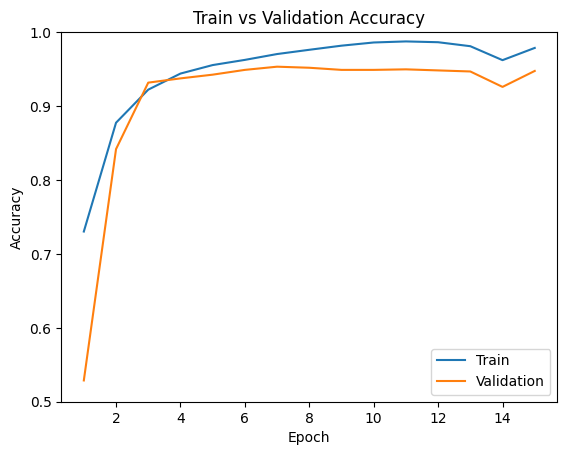

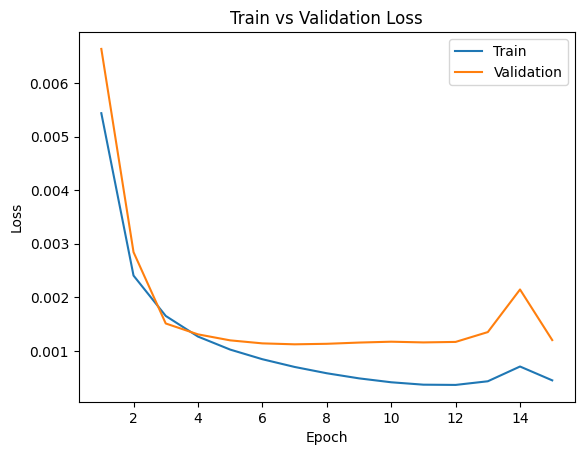

In [ ]:
#Used for plotting
train_acc = pd.read_csv('/content/model_resnet50_lr0.0001_bs128_layers3_optimadam_epoch14/model_resnet50_lr0.0001_bs128_layers3_optimadam_epoch14_train_acc.csv',header=None)
val_acc = pd.read_csv('/content/model_resnet50_lr0.0001_bs128_layers3_optimadam_epoch14/model_resnet50_lr0.0001_bs128_layers3_optimadam_epoch14_val_acc.csv',header=None)
train_loss = pd.read_csv('/content/model_resnet50_lr0.0001_bs128_layers3_optimadam_epoch14/model_resnet50_lr0.0001_bs128_layers3_optimadam_epoch14_train_loss.csv',header=None)
val_loss = pd.read_csv('/content/model_resnet50_lr0.0001_bs128_layers3_optimadam_epoch14/model_resnet50_lr0.0001_bs128_layers3_optimadam_epoch14_val_loss.csv',header=None)
plt.title("Train vs Validation Accuracy")
n = len(train_acc) # number of epochs
plt.plot(range(1,n+1), train_acc, label="Train")
plt.plot(range(1,n+1), val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
ax = plt.gca()
ax.set_ylim([0.5, 1.0])
plt.show()
plt.title("Train vs Validation Loss")
plt.plot(range(1,n+1), train_loss, label="Train")
plt.plot(range(1,n+1), val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

In [ ]:

probabilities = []
label_list = []
for imgs, labels in test_loader:

  rgb_batch = np.transpose(np.repeat(imgs[..., np.newaxis], 3, -1).squeeze(1),(0,3,1,2))
  labels = torch.flatten(labels.type(torch.LongTensor))
  if use_cuda:
    rgb_batch = rgb_batch.cuda()
    labels = labels.cuda()
  output = resnet_loaded(rgb_batch)
  loss = criterion(output, labels)

  #select index with maximum prediction score
  pred = output.max(1, keepdim=True)[1]
  probabilities.append(pred.cpu().detach().numpy()[0][0])
  label_list.append(labels.cpu().detach().numpy()[0])



In [ ]:

precision, recall, fscore, support = score(label_list, probabilities)

classes = {"Normal" : 0, "Viral Pneumonia": 1, "COVID":2}

for i in classes:
  print(i+':')

  print('\tprecision: {}'.format(round(precision[classes[i]]*100,2)))
  print('\trecall: {}'.format(round(recall[classes[i]]*100,2)))


Normal:
	precision: 97.34
	recall: 96.32
Viral Pneumonia:
	precision: 97.72
	recall: 97.72
COVID:
	precision: 96.55
	recall: 97.63


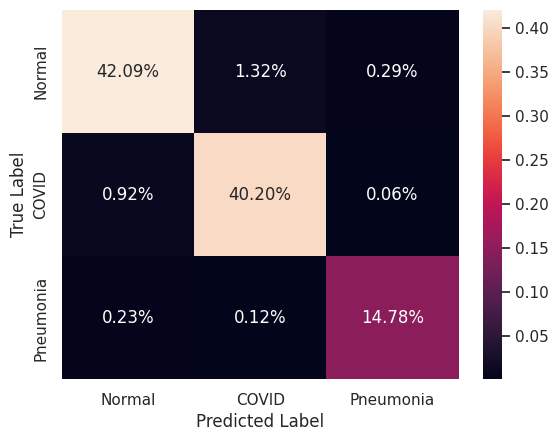

In [ ]:
plt.rcParams['figure.dpi'] = 100
sns.set_theme()
cf_matrix = confusion_matrix(label_list,probabilities, labels=[0,2,1])
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix),annot=True,fmt='.2%',xticklabels=['Normal','COVID','Pneumonia'],yticklabels=['Normal','COVID','Pneumonia'])
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label');

### Out of the Box Testing

In [ ]:
#From https://medium.com/analytics-vidhya/creating-a-custom-dataset-and-dataloader-in-pytorch-76f210a1df5d
class CustomDatasetOutofBox():
    def __init__(self,data_dir):
        file_list = glob.glob(data_dir + "/*")
        self.data = []
        for class_path in file_list:
            if class_path != data_dir+'/Lung_Opacity':
              class_name = class_path.split("/")[-1]
              for img_path in glob.glob(class_path + "/*.jpg"):
                  self.data.append([img_path, class_name])
        self.class_map = {"Normal" : 0, "Viral Pneumonia": 1, "COVID":2}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)

        grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = clahe.apply(grayimg)
        class_id = self.class_map[class_name]
        to_tensor = transforms.ToTensor()
        resizing = transforms.Resize(size=(299,299))
        img_tensor = to_tensor(resizing(transformsF.to_pil_image((img))))
        #Channel first format
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

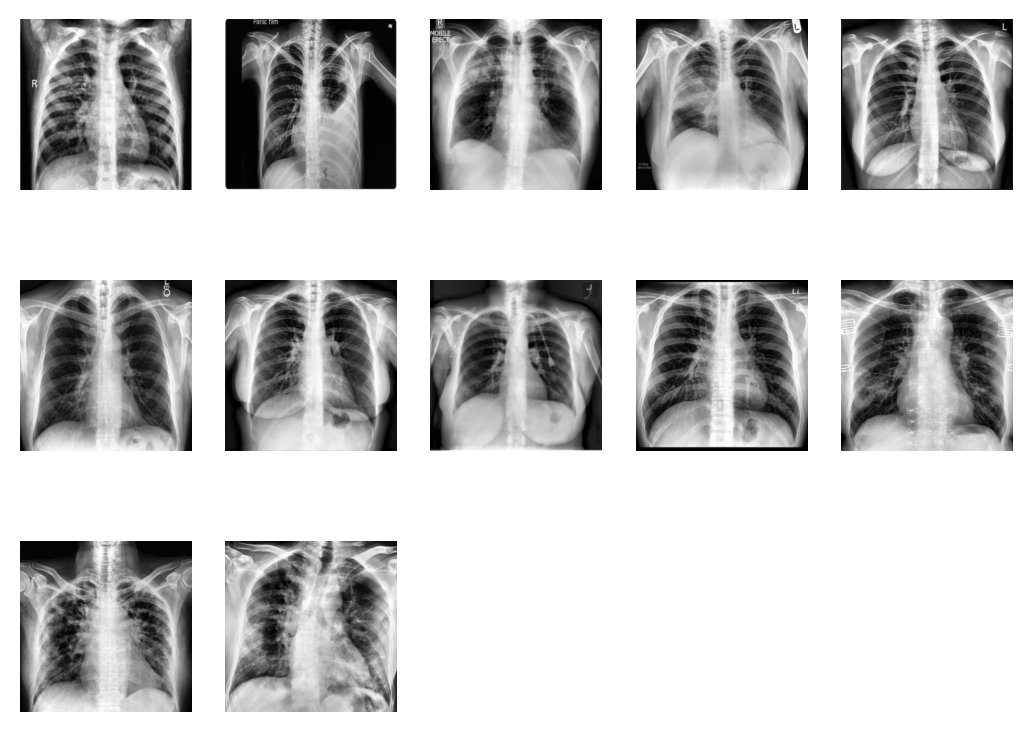

In [ ]:

data_loader = torch.utils.data.DataLoader(CustomDatasetOutofBox(data_dir), batch_size=1)
plt.rcParams['figure.dpi'] = 200
#FROM LAB 2
#Show some sample images from train loader (demonstrates that the data was shuffeld)
k = 0
for images, labels in data_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    # normalize pixel intensity values to [0, 1]
    #img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(image.squeeze(0),cmap='gray')

    k += 1
    if k > 14:
        break

In [ ]:
#FROM TUTORIAL 2
def evaluate_outofbox(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """

    correct = 0
    total = 0
    total_loss = 0.0
    total_epoch = 0
    for imgs, labels in loader:

        rgb_batch = np.transpose(np.repeat(imgs[..., np.newaxis], 3, -1).squeeze(1),(0,3,1,2))
        labels = torch.flatten(labels.type(torch.LongTensor))
        output = net(rgb_batch)
        loss = criterion(output, labels)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total_loss += loss.item()
        total_epoch += len(labels)
        total += rgb_batch.shape[0]
    loss = float(total_loss) / total
    accuracy = correct/total
    return accuracy, loss

In [ ]:

#Load the best model

weight_dir = "finalmodel_resnet50_lr0.0001_bs128_layers3_optimadam_epoch14.zip"
resnet_loaded = models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

#Freeze weights
#for param in resnet_loaded.parameters():
#    param.requires_grad = False

#Fully connected layers
resnet_loaded.fc = nn.Sequential(Flatten(),nn.Linear(2048,1028),nn.Linear(1028,512),nn.Linear(512,3))

resnet_loaded = load_model(weight_dir, resnet_loaded)
resnet_loaded.eval()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 69.2MB/s]


Archive:  /content/gdrive/MyDrive/APS360 Project/Model Weights/finalmodel_resnet50_lr0.0001_bs128_layers3_optimadam_epoch14.zip
   creating: model_resnet50_lr0.0001_bs128_layers3_optimadam_epoch14/
  inflating: model_resnet50_lr0.0001_bs128_layers3_optimadam_epoch14/model_resnet50_lr0.0001_bs128_layers3_optimadam_epoch14  
  inflating: model_resnet50_lr0.0001_bs128_layers3_optimadam_epoch14/model_resnet50_lr0.0001_bs128_layers3_optimadam_epoch13  
  inflating: model_resnet50_lr0.0001_bs128_layers3_optimadam_epoch14/model_resnet50_lr0.0001_bs128_layers3_optimadam_epoch14_val_loss.csv  
  inflating: model_resnet50_lr0.0001_bs128_layers3_optimadam_epoch14/model_resnet50_lr0.0001_bs128_layers3_optimadam_epoch12  
  inflating: model_resnet50_lr0.0001_bs128_layers3_optimadam_epoch14/model_resnet50_lr0.0001_bs128_layers3_optimadam_epoch11  
  inflating: model_resnet50_lr0.0001_bs128_layers3_optimadam_epoch14/model_resnet50_lr0.0001_bs128_layers3_optimadam_epoch5  
  inflating: model_resnet50_

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:

criterion = nn.CrossEntropyLoss()
print('The output accuracy for the out of the box samples is',str(round(evaluate_outofbox(resnet_loaded, data_loader, criterion)[0]*100,2))+'%')

1
1
0
0
1
1
1
1
1
1
1
1
The output accuracy for the out of the box samples is 83.33%


In [ ]:
probabilities = []
label_list = []
for imgs, labels in data_loader:

  rgb_batch = np.transpose(np.repeat(imgs[..., np.newaxis], 3, -1).squeeze(1),(0,3,1,2))
  labels = torch.flatten(labels.type(torch.LongTensor))
  output = resnet_loaded(rgb_batch)
  loss = criterion(output, labels)

  #select index with maximum prediction score
  pred = output.max(1, keepdim=True)[1]
  probabilities.append(pred.detach().numpy()[0][0])
  label_list.append(labels.detach().numpy()[0])

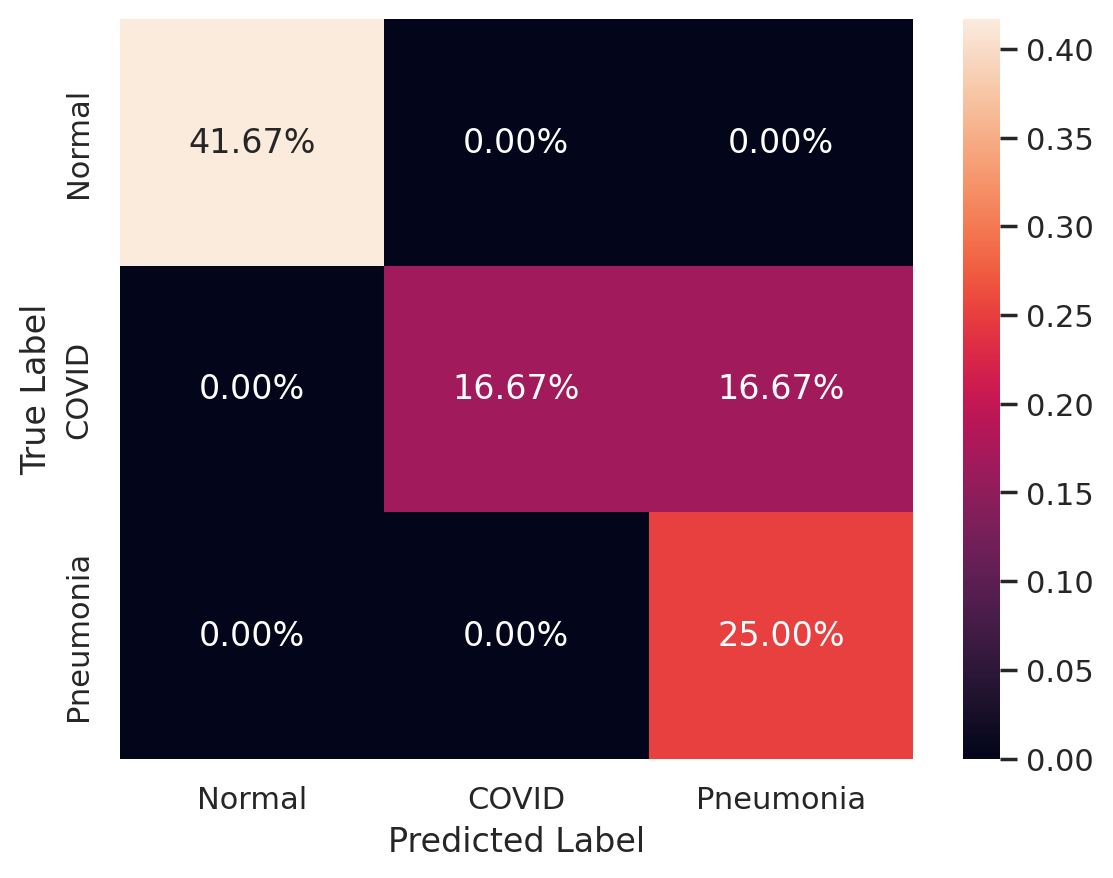

In [ ]:

sns.set_theme()
cf_matrix = confusion_matrix(label_list,probabilities)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix),annot=True,fmt='.2%',xticklabels=['Normal','COVID','Pneumonia'],yticklabels=['Normal','COVID','Pneumonia'])
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label');